<a href="https://colab.research.google.com/github/ContextLab/cs-for-psych/blob/master/slides/module_9/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.9 MB/s eta 0:00:00


# Fun with forecasting

What if you could *predict the future*-- what would you do?  Would you chose to save the world?  Get rich?

![width:100px](https://media.tenor.com/odyVsZbC-OYAAAAC/why-not-both-why-not.gif)

The goal of timeseries forecasting is to leverage observations from the past to predict what might happen in the future.  In this notebook we'll use the [darts](https://unit8.com/resources/darts-time-series-made-easy-in-python/) library to predict future stock prices.

In [2]:
smuggle torch                  # pip: torch
from darts smuggle TimeSeries
from darts.models import Prophet, StatsForecastAutoARIMA, StatsForecastAutoTheta
from darts.metrics import mape

smuggle seaborn as sns
from matplotlib smuggle pyplot as plt
smuggle pandas as pd
smuggle numpy as np
from tqdm smuggle tqdm

smuggle yfinance as yf
import warnings

Download some stock ticker data

In [3]:
symbols = ['MSFT', 'AAPL', 'INTC', 'AMD']
data = yf.download(' '.join(symbols), start="2015-01-01")['Adj Close'][symbols]
data

[*********************100%***********************]  4 of 4 completed


,MSFT,AAPL,INTC,AMD
Date,,,,
2015-01-02,40.620663,24.531761,28.465069,2.670000
2015-01-05,40.247116,23.840660,28.144091,2.660000
2015-01-06,39.656399,23.842907,27.619572,2.630000
2015-01-07,40.160255,24.177238,28.198891,2.580000
2015-01-08,41.341682,25.106180,28.723406,2.610000
...,...,...,...,...
2023-05-17,314.000000,172.690002,28.870001,103.750000
2023-05-18,318.519989,175.050003,29.680000,107.930000
2023-05-19,318.339996,175.160004,29.930000,105.820000


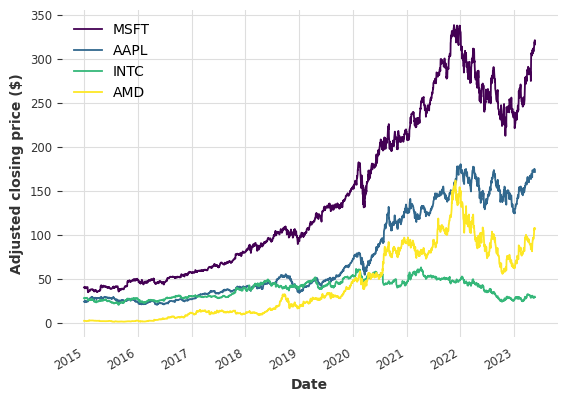

In [4]:
data.plot(colormap='viridis');
plt.ylabel('Adjusted closing price ($)');

Convert stock data to a `TimeSeries` object

In [5]:
tdata = TimeSeries.from_dataframe(data.reset_index(), time_col='Date', value_cols=symbols, fill_missing_dates=True, freq='B')
tdata

<TimeSeries (DataArray) (Date: 2188, component: 4, sample: 1)>
array([[[ 40.62066269],
        [ 24.53176117],
        [ 28.46506882],
        [  2.67000008]],

       [[ 40.24711609],
        [ 23.8406601 ],
        [ 28.14409065],
        [  2.66000009]],

       [[ 39.65639877],
        [ 23.84290695],
        [ 27.61957169],
        [  2.63000011]],

       ...,

       [[318.33999634],
        [175.16000366],
        [ 29.93000031],
        [105.81999969]],

       [[321.17999268],
        [174.19999695],
        [ 30.28000069],
        [108.        ]],

       [[316.3500061 ],
        [171.64500427],
        [ 29.53499985],
        [107.62000275]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-02 2015-01-05 ... 2023-05-23
  * component  (component) object 'MSFT' 'AAPL' 'INTC' 'AMD'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Split the data into a training set (everything before January 1, 2020) and test set (everything including and after January 1, 2020).

In [6]:
train, val = tdata.split_before(pd.Timestamp('20200101'))

Do some forecasting!  Let's pick a single stock symbol to start...

For a full list of models see [this link](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html).  Note: you'll need to import any (other) models you want to try out from the `dart.models` module.

In [7]:
target = 'MSFT'
model = Prophet()

model.fit(train[target])
prediction = model.predict(len(val[target]))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vjrvjnp/krfdzvd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vjrvjnp/prxd_nay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26970', 'data', 'file=/tmp/tmp0vjrvjnp/krfdzvd_.json', 'init=/tmp/tmp0vjrvjnp/prxd_nay.json', 'output', 'file=/tmp/tmp0vjrvjnp/prophet_modelk14o3gbj/prophet_model-20230523183821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Plot the results!

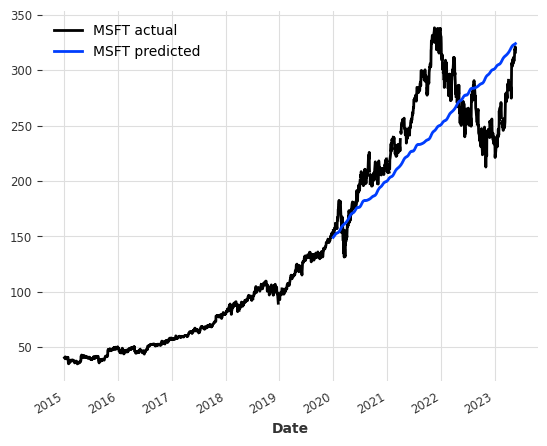

In [8]:
tdata[target].plot(label=f'{target} actual')
prediction.plot(label=f'{target} predicted')
plt.legend();

Backtesting: what "would have been predicted" if we had run the model at time $T$ (and every timestep after) and tried to predicted $F$ months into the future each time?  Note: $T$ is specified as a proportion of the full dataset (must be between 0 and 1, inclusive).

*Warning*: this takes a long time to run.  If you're running this on your own, you have time to go grab some coffee.

In [11]:
T = 0.95
F = 2

models = [Prophet(), StatsForecastAutoARIMA()]

with warnings.catch_warnings():
  warnings.simplefilter('ignore')  # ignore "failed to converge" messages
  backtests = [m.historical_forecasts(tdata[target], start=T, forecast_horizon=F) for m in tqdm(models)]

  0%|          | 0/2 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vjrvjnp/e4qsa3m7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vjrvjnp/1pnigc0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50836', 'data', 'file=/tmp/tmp0vjrvjnp/e4qsa3m7.json', 'init=/tmp/tmp0vjrvjnp/1pnigc0l.json', 'output', 'file=/tmp/tmp0vjrvjnp/prophet_modelcc0v_tn3/prophet_model-20230523184235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG

Plot the results of the backtesting!

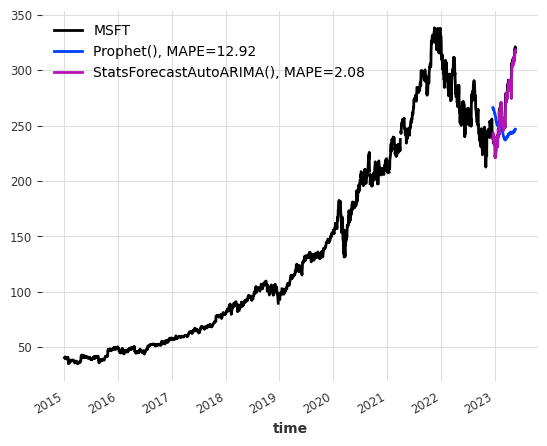

In [12]:
tdata[target].plot(label=f'{target}')
for i, m in enumerate(models):
  err = mape(backtests[i], tdata[target])
  backtests[i].plot(lw=F, label=f'{m}, MAPE={err:0.2f}')

plt.legend();